Streaming output truncated to the last 5000 lines.
Player 1 dashed Player 3
Player 3 dashed Player 4
Player 1 dashed Player 3
Player 1 dashed Player 3
Player 1 dashed Player 3
Player 1 dashed Player 3
Episode 401: Winner - Player 1 with a score of 6.5
Player 2 dashed Player 4
Player 1 dashed Player 3
Player 2 dashed Player 4
Player 4 dashed Player 1
Player 3 dashed Player 4
Player 3 dashed Player 2
Player 3 dashed Player 2
Player 3 dashed Player 2
Episode 402: Winner - Player 3 with a score of 3.5
Player 2 dashed Player 4
Player 1 dashed Player 2
Player 1 dashed Player 3
Player 3 dashed Player 2
Player 4 dashed Player 1
Player 1 dashed Player 2
Player 1 dashed Player 3
Player 2 dashed Player 4
Player 3 dashed Player 2
Player 3 dashed Player 4
Player 1 dashed Player 2
Player 1 dashed Player 3
Player 1 dashed Player 3
Player 1 dashed Player 3
Episode 403: Winner - Player 1 with a score of 7.5
Player 1 dashed Player 2
Player 2 dashed Player 4
Player 2 dashed Player 4
Player 4 dashed Playe

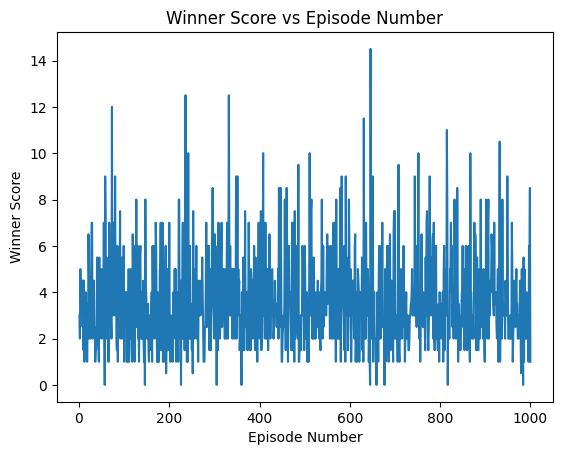

In [1]:
import pygame
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Initialize Pygame
pygame.init()

# Constants
GRID_SIZE = 10
CELL_SIZE = 50  # Adjusted size for 8x8 grid within a 16x16 screen
SCREEN_SIZE = (800, 800)  # Added space for scores
WHITE = (255, 255, 255)  # This is just a placeholder, and it won't affect the display.
RED = (255,0,0)

# Player class
class Player:
    def __init__(self, x, y, image_path):
        self.x = x
        self.y = y
        self.score = 0
        self.image = pygame.image.load(image_path)
        self.initial_x = x  # Store the initial x position
        self.initial_y = y  # Store the initial y position

    def reset(self):
        # Reset the player's state to the initial position and score
        self.x = self.initial_x
        self.y = self.initial_y
        self.score = 0

    def move(self, dx, dy):
        new_x = (self.x + dx) % GRID_SIZE
        new_y = (self.y + dy) % GRID_SIZE

        # Check if the new position is within the boundaries
        if 0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE:
            self.x = new_x
            self.y = new_y

    def dash(self, other_player):
        self.score += 1
        other_player.score -= 0.5

# Initialize players with car images
player1 = Player(0, 0, "player1.jpg")
player2 = Player(0, GRID_SIZE - 1, "player2.jpg")
player3 = Player(GRID_SIZE - 1, 0, "player3.jpg")
player4 = Player(GRID_SIZE - 1, GRID_SIZE - 1, "player4.jpg")

players = [player1, player2, player3, player4]

def get_state(players):
    return frozenset((player.x, player.y) for player in players)

def q_learning_update(q_values, state, action, reward, next_state, alpha, gamma):
    flat_state = tuple(sorted(tuple(coord for pos in state for coord in pos)))
    flat_next_state = tuple(sorted(tuple(coord for pos in next_state for coord in pos)))
    action_tuple = (action,)  # Convert action to a tuple

    if flat_state not in q_values:
        q_values[flat_state] = {action_tuple: 0.0}
    elif action_tuple not in q_values[flat_state]:
        q_values[flat_state][action_tuple] = 0.0

    q_values[flat_state][action_tuple] += alpha * (reward + gamma * max(q_values.get(flat_next_state, {}).values(), default=0.0) - q_values[flat_state][action_tuple])

def choose_action(q_values, state, epsilon):
    if state not in q_values or np.random.uniform(0, 1) < epsilon:
        return np.random.choice(4)  # Assuming 4 possible actions (four directions to move)
    else:
        return np.argmax(q_values[state])

# Initialize Pygame screen
screen = pygame.display.set_mode(SCREEN_SIZE)
pygame.display.set_caption("Player Dash Game")

# Load car images
car_images = [
    pygame.image.load("player1.jpg"),
    pygame.image.load("player2.jpg"),
    pygame.image.load("player3.jpg"),
    pygame.image.load("player4.jpg"),
]

# RL parameters
q_values = dict()
epsilon = 0.05
learning_rate = 0.05
discount_factor = 0.6

# Training parameters
num_episodes = 1000
game_duration_per_episode = 15  # seconds

# Lists to store episode numbers and winner scores
episode_numbers = []
winner_scores = []

# Game loop for training multiple episodes
for episode in range(num_episodes):
    # Reset players and Q-values for a new episode
    for player in players:
        player.reset()

    q_values.clear()  # Reset Q-values for a new episode

    start_time = time.time()
    while time.time() - start_time < game_duration_per_episode:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        # Handle player movements using RL
        for i, player in enumerate(players):
            state = get_state(players)
            action = choose_action(q_values, state, epsilon)
            dx, dy = [(0, 1), (1, 0), (0, -1), (-1, 0)][action]
            player.move(dx, dy)

            for other_player in players:
                if player != other_player and player.x == other_player.x and player.y == other_player.y:
                    player.dash(other_player)
                    print(f"Player {players.index(player) + 1} dashed Player {players.index(other_player) + 1}")

            next_state = get_state(players)
            reward = player.score

            # Convert state and next_state to flat tuples
            state_key = tuple(state)
            next_state_key = tuple(next_state)

            q_learning_update(q_values, state_key, action, reward, next_state_key, learning_rate, discount_factor)

        # Draw the grid and players
        screen.fill(WHITE)

        # Draw the scores above the grid
        font = pygame.font.Font(None, 20)
        for i, player in enumerate(players):
            score_text = font.render(f"Player {i + 1} Score: {player.score}", True, RED)
            screen.blit(score_text, (10 + i * 200, 550))

        # Draw the time remaining on the right side
        remaining_time = max(0, game_duration_per_episode - (time.time() - start_time))
        time_text = font.render(f"Time: {int(remaining_time)} seconds", True, RED)
        screen.blit(time_text, (SCREEN_SIZE[0] - time_text.get_width() - 10, 10))

        # Draw the grid
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                pygame.draw.rect(screen, (200, 200, 200), (i * CELL_SIZE, j * CELL_SIZE, CELL_SIZE, CELL_SIZE), 1)

        # Draw the car images
        for i, player in enumerate(players):
            car_image = pygame.transform.scale(car_images[i], (CELL_SIZE, CELL_SIZE))
            screen.blit(car_image, (player.x * CELL_SIZE, player.y * CELL_SIZE))

        pygame.display.flip()
        pygame.time.delay(500)  # Delay to slow down the game for visualization purposes

    # Print the winner and scores for each episode
    winner = max(players, key=lambda player: player.score)
    print(f"Episode {episode + 1}: Winner - Player {players.index(winner) + 1} with a score of {winner.score}")

    # Store episode number and winner score for plotting
    episode_numbers.append(episode + 1)
    winner_scores.append(winner.score)

# Find the winners (players with the highest score)
max_score = max(player.score for player in players)
winners = [player for player in players if player.score == max_score]

# Display the winners and their scores for 2 seconds
screen.fill(WHITE)
if winners:
    if len(winners) == 1:
        winner_text = font.render(f"Winner: Player {players.index(winners[0]) + 1} - Score: {winners[0].score}", True, RED)
        screen.blit(winner_text, (SCREEN_SIZE[0] // 2 - winner_text.get_width() // 2, SCREEN_SIZE[1] // 2 - winner_text.get_height() // 2))
    else:
        winners_text = font.render("Winners:", True, RED)
        screen.blit(winners_text, (SCREEN_SIZE[0] // 2 - winners_text.get_width() // 2, SCREEN_SIZE[1] // 2 - winners_text.get_height() // 2))

        y_offset = SCREEN_SIZE[1] // 2
        for winner in winners:
            winner_text = font.render(f"Player {players.index(winner) + 1} - Score: {winner.score}", True, RED)
            screen.blit(winner_text, (SCREEN_SIZE[0] // 2 - winner_text.get_width() // 2, y_offset))
            y_offset += winner_text.get_height()

pygame.display.flip()
pygame.time.delay(500)

# Plotting the results
plt.plot(episode_numbers, winner_scores)
plt.title('Winner Score vs Episode Number')
plt.xlabel('Episode Number')
plt.ylabel('Winner Score')
plt.show()

pygame.quit()
#sys.exit()